In [45]:
import json
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from matplotlib.colors import BoundaryNorm, ListedColormap
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec
import matplotlib.cm as cm
import matplotlib.colors as colors
import string
import matplotlib as mpl
mpl.rcParams['figure.figsize']=(20,9)
mpl.style.use('ggplot')

In [4]:
# Summation of the value insde a dictionary
def dictsum(myDict):
    sum = 0
    for i in myDict:
        sum = sum + myDict[i]
    return sum

# 1. GTAP

In [5]:
#@title Read files
# population
file = open("First_review_data/Total_pop_gtap.json", "r")
population_gtap = file.read()
population_gtap = json.loads(population_gtap)

con_mort_tol_gtap = pd.read_csv('First_review_data/S3.csv',index_col=0)
# Row sum: total deaths happen in that country
con_total_gtap = dict(con_mort_tol_gtap.sum(axis=1))

# Col sum: total deaths caused by that country
con_caused_gtap = dict(con_mort_tol_gtap.sum(axis=0))

file = open("Data/final_demand_gtap.json", "r")
final_demand_gtap = file.read()
final_demand_gtap = json.loads(final_demand_gtap)

# gdp
file = open("Data/GDP_gtap_dict.json", "r")
gdp_gtap = file.read()
gdp_gtap = json.loads(gdp_gtap) # unit:usd

# GTAP is in 1000000 USD
for i in final_demand_gtap:
    final_demand_gtap[i] = final_demand_gtap[i] * 1000000

demand_capita_gtap = {}
for country in population_gtap:
    if population_gtap[country] == 0:
        demand_capita_gtap[country] = 0
    else:
        demand_capita_gtap[country] = final_demand_gtap[country] / population_gtap[country]

Gtap_regions = {'PRI':['PRI'],
               'XCB':['AIA','ATG','ABW','BHS','BRB','VGB','CYM','CUB','DMA','GRD','HTI','MSR','KNA','LCA','VCT','TCA','VIR'],
               'XCF':['CAF','TCD','COG','GNQ','GAB','STP'],
               'XEC':['BDI','COM','DJI','ERI','SYC','SOM','SDN'], # gtap ONLY contains Sudan, without South Sudan
               'XER':['AND','BIH','GIB','GGY','VAT','IMN','JEY','MKD','MCO','MNE','SMR','SRB'],
               'XNA':['BMU','GRL','SPM'],
               'XNF':['DZA','LBY','SAH','ESH'], # 'SAH' is changed from 'ESH': Western Sahara
               'XOC':['ASM','COK','FJI','PYF','GUM','KIR','MHL','FSM','NRU','NCL','NIU','MNP','PLW','PNG','PCN','WSM','SLB',
                      'TON','TUV','VUT','WLF'], #'TKL' Tokelau is removed since it's counted as New Zealand
               'XSE':['MMR','TLS'],
               'XSM':['FLK','GUY','SUR'],
               'XWF':['CPV','GMB','GNB','LBR','MLI','MRT','NER','SHN','SLE'],
               'XAC':['AGO','COD'],
               'XEA':['PRK','MAC'],
               'XSA':['AFG','BTN','MDV'],
               'XSC':['LSO','SWZ'],
               'XSU':['TJK','TKM','UZB'],
               'XWS':['IRQ','LBN','PSX','YEM','SYR'],
               'XEF':['ISL','LIE'],
               'XCA':['BLZ'],
               'XEE':['MDA']}
                #XTW # the rest of the world

In [6]:
del gdp_gtap['XTW']

In [7]:
poor_coun_import_death_gtap = {}
for i in gdp_gtap:
  if gdp_gtap[i] / population_gtap[i] < 10000: # countries with per capita GDP < 10000
    poor_coun_import_death_gtap[i] = 0 # Count the number of deaths caused by wealthier countries
    for j in gdp_gtap:
      if gdp_gtap[j] / population_gtap[j] >= 10000:
        poor_coun_import_death_gtap[i] += con_mort_tol_gtap[j][i] # The number of deaths caused by country j (country with per capita GDP greater than 10k) and happen in country i

poor_percent_gtap = {}
for country in poor_coun_import_death_gtap:
  poor_percent_gtap[country] = poor_coun_import_death_gtap[country] / con_total_gtap[country]
  # The proportion of deaths in a poorer country attributable to wealthier countries' activities out of the total deaths in that poorer country.
# dict(sorted(poor_percent_gtap.items(), key=lambda item: item[1]))

In [9]:
len({k: v for k, v in poor_percent_gtap.items() if v > 0.20})/ len(poor_percent_gtap), len(poor_percent_gtap)

(0.9024390243902439, 82)

In [10]:
wealthy_coun_import_death_gtap = {}
for i in gdp_gtap:
  if gdp_gtap[i] / population_gtap[i] > 20000: # countries with per capita GDP > 20000
    wealthy_coun_import_death_gtap[i] = 0 # Count the number of deaths happen in poorer countries
    for j in gdp_gtap:
      if gdp_gtap[j] / population_gtap[j] < 10000:
        wealthy_coun_import_death_gtap[i] += con_mort_tol_gtap[i][j] # The number of deaths caused by country i (country with per capita GDP greater than 20k) and happen in country j

wealthy_percent_gtap = {}
for country in wealthy_coun_import_death_gtap:
  wealthy_percent_gtap[country] = wealthy_coun_import_death_gtap[country] / con_caused_gtap[country]
  # The proportion of deaths in a poorer country caused by wealthier countries to the total number of deaths caused by these wealthier countries.
# dict(sorted(wealthy_percent_gtap.items(), key=lambda item: item[1]))

In [11]:
len({k: v for k, v in wealthy_percent_gtap.items() if v > 0.5})/ len(wealthy_percent_gtap), len(wealthy_percent_gtap)

(0.9743589743589743, 39)

In [12]:
#@title 1.1 Calculation 1: Fraction of deaths caused by foreign demand and occur in the current country
# deaths happen in that country caused by foreign demand
death_by_allforeigndemand_gtap = {} # deaths caused by all foreign demand
death_by_G50foreigndemand_gtap = {} # deaths caused by demand from countries where demand/capita is >50% more than demand/capita in current country
death_by_G100foreigndemand_gtap = {} # deaths caused by demand from countries where demand/capita is >100% more than demand/capita in current country
for i in demand_capita_gtap:
    death_by_allforeigndemand_gtap[i] = 0
    death_by_G50foreigndemand_gtap[i] = 0
    death_by_G100foreigndemand_gtap[i] = 0
    for j in demand_capita_gtap:
        if i != j:
            death_by_allforeigndemand_gtap[i] += con_mort_tol_gtap[j][i] # deaths caused by j and happen in i

            if demand_capita_gtap[j] >= 1.5 * demand_capita_gtap[i]:
                death_by_G50foreigndemand_gtap[i] += con_mort_tol_gtap[j][i]

            if demand_capita_gtap[j] >= 2 * demand_capita_gtap[i]:
                death_by_G100foreigndemand_gtap[i] += con_mort_tol_gtap[j][i]

# total deaths happen in that country
con_dom_world_gtap = {}
for country in con_mort_tol_gtap:
    con_dom_world_gtap[country] = {}
    con_dom_world_gtap[country]['domestic'] = con_mort_tol_gtap[country][country]
    con_dom_world_gtap[country]['world'] = con_total_gtap[country]
    con_dom_world_gtap[country]['OtherPartofWorld'] = con_dom_world_gtap[country]['world'] - con_dom_world_gtap[country]['domestic']

# total deaths happen in that country RATIO
allforeign_world_gtap = {}
G50foreign_world_gtap = {}
G100foreign_world_gtap = {}
for country in con_dom_world_gtap:
    if con_dom_world_gtap[country]['world'] != 0:
        allforeign_world_gtap[country] = death_by_allforeigndemand_gtap[country] / con_dom_world_gtap[country]['world']
        G50foreign_world_gtap[country] = death_by_G50foreigndemand_gtap[country] / con_dom_world_gtap[country]['world']
        G100foreign_world_gtap[country] = death_by_G100foreigndemand_gtap[country] / con_dom_world_gtap[country]['world']
    else:
        allforeign_world_gtap[country] = 0
        G50foreign_world_gtap[country] = 0
        G100foreign_world_gtap[country] = 0

In [13]:
# Pololation weighted average for Fraction of deaths caused by foreign demand and occur in the current country
pwa_allforeign_world_gtap = 0
pwa_G50foreign_world_gtap = 0
pwa_G100foreign_world_gtap = 0

for country in population_gtap:
  pwa_allforeign_world_gtap += population_gtap[country] * allforeign_world_gtap[country]
  pwa_G50foreign_world_gtap += population_gtap[country] * G50foreign_world_gtap[country]
  pwa_G100foreign_world_gtap += population_gtap[country] * G100foreign_world_gtap[country]

pwa_allforeign_world_gtap = pwa_allforeign_world_gtap / dictsum(population_gtap)
pwa_G50foreign_world_gtap = pwa_G50foreign_world_gtap / dictsum(population_gtap)
pwa_G100foreign_world_gtap = pwa_G100foreign_world_gtap / dictsum(population_gtap)
pwa_allforeign_world_gtap,pwa_G50foreign_world_gtap,pwa_G100foreign_world_gtap

(np.float64(0.5181140338885313),
 np.float64(0.34017973029886894),
 np.float64(0.31871347100977654))

In [14]:
pop = 0
for country in G100foreign_world_gtap:
  if G100foreign_world_gtap[country] > 0.5:
    pop+=population_gtap[country]
pop

1080719656.676905

In [15]:
#@title 1.2 Calculation 2: Fraction of deaths caused by consumption in this country that occur in other countries
# deaths caused by this country and happen in foreign country
death_allforeign_gtap = {} # deaths caused by consumption in this country that occur in ALL other countries
death_L30foreigndemand_gtap = {} # deaths caused by consumption in this country that occur in countries with >33% lower demand/capita than the current country
death_L50foreigndemand_gtap = {} # deaths caused by consumption in this country that occur in countries with >50% lower demand/capita than the current country

for i in con_mort_tol_gtap:
    death_allforeign_gtap[i] = 0
    death_L30foreigndemand_gtap[i] = 0
    death_L50foreigndemand_gtap[i] = 0
    for j in con_mort_tol_gtap:
        if i != j:
            death_allforeign_gtap[i] += con_mort_tol_gtap[i][j] # deaths caused by i and happen in j

            if demand_capita_gtap[j] <= 0.7 * demand_capita_gtap[i]:
                death_L30foreigndemand_gtap[i] += con_mort_tol_gtap[i][j]

            if demand_capita_gtap[j] <= 0.5 * demand_capita_gtap[i]:
                death_L50foreigndemand_gtap[i] += con_mort_tol_gtap[i][j]

# total deaths caused by that country
con_cause_dom_world_gtap = {}
for country in con_mort_tol_gtap:
    con_cause_dom_world_gtap[country] = {}
    con_cause_dom_world_gtap[country]['domestic'] = con_mort_tol_gtap[country][country]
    con_cause_dom_world_gtap[country]['world'] = con_caused_gtap[country]
    con_cause_dom_world_gtap[country]['OtherPartofWorld'] = con_cause_dom_world_gtap[country]['world'] - con_cause_dom_world_gtap[country]['domestic']

# total deaths caused by that country RATIO
cause_allforeign_world_gtap = {}
cause_L30foreign_world_gtap = {}
cause_L50foreign_world_gtap = {}
for country in con_cause_dom_world_gtap:
    if con_cause_dom_world_gtap[country]['world'] != 0:
        cause_allforeign_world_gtap[country] = death_allforeign_gtap[country] / con_cause_dom_world_gtap[country]['world']
        cause_L30foreign_world_gtap[country] = death_L30foreigndemand_gtap[country] / con_cause_dom_world_gtap[country]['world']
        cause_L50foreign_world_gtap[country] = death_L50foreigndemand_gtap[country] / con_cause_dom_world_gtap[country]['world']
    else:
        cause_allforeign_world_gtap[country] = 0
        cause_L30foreign_world_gtap[country] = 0
        cause_L50foreign_world_gtap[country] = 0

In [16]:
total_Deaths_gtap = {"NZL": 547.1710943234342, "XOC": 37.632847262820476, "USA": 104184.66579238027, "RUS": 85619.0166190897, "FRA": 12697.544898653934, "CAN": 10923.348450292044, "MEX": 79640.91266454595, "CHL": 10896.342639191287, "ECU": 9330.741366254204, "GTM": 8398.922141583636, "CRI": 1254.0691045497583, "SLV": 3723.9089873468415, "XCA": 4.261701811610864, "HND": 1862.0865139134812, "NIC": 696.1396365179035, "PER": 20217.881407137553, "XCB": 9387.26733600714, "COL": 27374.114100858635, "PAN": 1116.1595250898401, "JAM": 1846.1008687256415, "BRA": 112402.43884906666, "ARG": 19474.388513554288, "DOM": 5347.359294158705, "VEN": 12875.841005516491, "XNA": 0.0, "NLD": 6676.537813022756, "BOL": 4641.232026794473, "PRI": 249.13514020025417, "PRY": 1028.4527481523637, "XSM": 21.865740746330864, "TTO": 370.2719300250046, "URY": 1425.9543673695707, "PRT": 2439.3314824412714, "XWF": 42262.04151703402, "XEF": 0.0, "SEN": 7612.809437101417, "ESP": 27902.2620958705, "GIN": 4469.689014746005, "MAR": 23322.8464676969, "XNF": 21315.388936363215, "GBR": 6944.2213146593795, "IRL": 122.56744127170107, "DNK": 1182.059410719045, "NOR": 40.080026802285225, "CIV": 3619.5557085097753, "XER": 7453.193311441571, "BFA": 11571.988603647831, "GHA": 7805.264445107065, "TGO": 2502.5069323560097, "BEL": 4817.88362702517, "BEN": 3827.62176374147, "DEU": 40556.693100145436, "XCF": 15691.917551662838, "NGA": 84797.17858395408, "ITA": 43883.654437081335, "LUX": 100.75518402791597, "CHE": 1417.0691831167815, "TUN": 7920.360811552916, "NAM": 1165.954175023233, "XAC": 45503.63347694087, "CMR": 8897.942501369249, "SWE": 396.1587100192456, "AUT": 3243.511948914257, "CZE": 7027.185430579352, "ZAF": 40976.05579842906, "HRV": 2555.4886888996657, "MLT": 357.6957620025623, "SVN": 927.2687340459299, "POL": 24823.673080115175, "HUN": 8001.0431607921255, "SVK": 3238.623482365545, "GRC": 17106.751628188827, "ALB": 1792.2882393750983, "LTU": 629.3701896436659, "LVA": 267.04240268767876, "FIN": 232.3427921633378, "BWA": 1134.663893128954, "ROU": 28668.51332897198, "BGR": 10889.459654610422, "EST": 74.1722256888058, "ZMB": 6243.887954511439, "XEC": 47978.05379969388, "UKR": 36819.65814872153, "EGY": 71250.56546737274, "BLR": 3691.932498113821, "ZWE": 3461.70639684946, "TUR": 54579.14963653243, "XSC": 3934.1466976623187, "XEE": 2027.5094673896735, "CYP": 925.610505481904, "RWA": 3203.1456598822874, "TZA": 10580.571362354867, "UGA": 13582.366741724774, "MOZ": 5754.833591558975, "ETH": 39272.36855035956, "ISR": 5190.592659128192, "KEN": 10546.282279550156, "XWS": 72308.95535057267, "MWI": 3060.79251028105, "JOR": 2222.9389016913237, "SAU": 19831.855501001024, "GEO": 4413.494803099459, "MDG": 2356.801316682343, "ARM": 2799.4890697885717, "IRN": 53070.0698074065, "AZE": 9990.99346828919, "KWT": 1231.2090627054627, "KAZ": 10250.716026683418, "BHR": 1019.8369800497462, "QAT": 1563.6185967573992, "OMN": 1513.2431537150017, "XSU": 22368.491154797, "ARE": 4106.518300704578, "MUS": 351.16336502517214, "XSA": 24208.55747856603, "PAK": 157365.94543686768, "TJK": 1699.2902047148532, "IND": 940623.5738784531, "KGZ": 2920.2458213585915, "CHN": 1487766.9837519769, "LKA": 15866.177241580639, "NPL": 26764.39493459112, "BGD": 80972.0840810707, "XSE": 13605.895414337905, "MNG": 1124.2336192450116, "IDN": 218171.31140267913, "THA": 49204.96830547403, "AUS": 6504.194485597545, "MYS": 19329.421377712857, "LAO": 2203.1007151107947, "KHM": 6885.191327688254, "VNM": 68714.7599244136, "SGP": 3375.4422473002583, "BRN": 71.7486909998205, "PHL": 42913.2245659962, "TWN": 21539.10001202435, "HKG": 5909.66529201524, "JPN": 117424.64147662441, "XEA": 27750.364253955202, "KOR": 24195.32060722542}

In [17]:
# Pololation weighted average for Fraction of deaths caused by domestic demand and occur in the other country
pwa_cause_allforeign_world_gtap = 0
pwa_cause_G30foreign_world_gtap = 0
pwa_cause_G50foreign_world_gtap = 0

for country in population_gtap:
  pwa_cause_allforeign_world_gtap += population_gtap[country] * cause_allforeign_world_gtap[country]
  pwa_cause_G30foreign_world_gtap += population_gtap[country] * cause_L30foreign_world_gtap[country]
  pwa_cause_G50foreign_world_gtap += population_gtap[country] * cause_L50foreign_world_gtap[country]

pwa_cause_allforeign_world_gtap = pwa_cause_allforeign_world_gtap / dictsum(population_gtap)
pwa_cause_G30foreign_world_gtap = pwa_cause_G30foreign_world_gtap / dictsum(population_gtap)
pwa_cause_G50foreign_world_gtap = pwa_cause_G50foreign_world_gtap / dictsum(population_gtap)
pwa_cause_allforeign_world_gtap,pwa_cause_G30foreign_world_gtap,pwa_cause_G50foreign_world_gtap

(np.float64(0.47094227346996115),
 np.float64(0.18891062941154527),
 np.float64(0.16969038164694625))

In [18]:
count = 0
for country in cause_allforeign_world_gtap:
  if cause_allforeign_world_gtap[country] > 0.5:
    count+=1
count/len(cause_allforeign_world_gtap)

0.8297872340425532

In [19]:
#@title 1.3 Ratio plot preparation for GTAP
df_shp_gtap = gpd.read_file('Data/10m_cultural/ne_10m_admin_0_countries.shp')

df_shp_gtap["allforeign_world"] = np.nan
df_shp_gtap["G50foreign_world"] = np.nan
df_shp_gtap["G100foreign_world"] = np.nan
df_shp_gtap["cause_allforeign_world"] = np.nan
df_shp_gtap["cause_L30foreign_world"] = np.nan
df_shp_gtap["cause_L50foreign_world"] = np.nan
df_shp_gtap['gdp_per_capita'] = np.nan
df_shp_gtap['population'] = np.nan


for i in con_mort_tol_gtap:
    if i[0] != 'X':
        df_shp_gtap.loc[df_shp_gtap['ADM0_A3'] == i,"allforeign_world"] = allforeign_world_gtap[i]
        df_shp_gtap.loc[df_shp_gtap['ADM0_A3'] == i,"G50foreign_world"] = G50foreign_world_gtap[i]
        df_shp_gtap.loc[df_shp_gtap['ADM0_A3'] == i,"G100foreign_world"] = G100foreign_world_gtap[i]
        df_shp_gtap.loc[df_shp_gtap['ADM0_A3'] == i,"cause_allforeign_world"] = cause_allforeign_world_gtap[i]
        df_shp_gtap.loc[df_shp_gtap['ADM0_A3'] == i,"cause_L30foreign_world"] = cause_L30foreign_world_gtap[i]
        df_shp_gtap.loc[df_shp_gtap['ADM0_A3'] == i,"cause_L50foreign_world"] = cause_L50foreign_world_gtap[i]
        df_shp_gtap.loc[df_shp_gtap['ADM0_A3'] == i,"gdp_per_capita"] = gdp_gtap[i] / population_gtap[i]
        df_shp_gtap.loc[df_shp_gtap['ADM0_A3'] == i,"population"] = population_gtap[i]

    elif i[0] == 'X' and i != 'XTW': # Assign the value of the region to its member countries
        for j in Gtap_regions[i]:
            df_shp_gtap.loc[df_shp_gtap['ADM0_A3'] == j,"allforeign_world"] = allforeign_world_gtap[i]
            df_shp_gtap.loc[df_shp_gtap['ADM0_A3'] == j,"G50foreign_world"] = G50foreign_world_gtap[i]
            df_shp_gtap.loc[df_shp_gtap['ADM0_A3'] == j,"G100foreign_world"] = G100foreign_world_gtap[i]
            df_shp_gtap.loc[df_shp_gtap['ADM0_A3'] == j,"cause_allforeign_world"] = cause_allforeign_world_gtap[i]
            df_shp_gtap.loc[df_shp_gtap['ADM0_A3'] == j,"cause_L30foreign_world"] = cause_L30foreign_world_gtap[i]
            df_shp_gtap.loc[df_shp_gtap['ADM0_A3'] == j,"cause_L50foreign_world"] = cause_L50foreign_world_gtap[i]
            df_shp_gtap.loc[df_shp_gtap['ADM0_A3'] == j,"gdp_per_capita"] = gdp_gtap[i] / population_gtap[i]
            df_shp_gtap.loc[df_shp_gtap['ADM0_A3'] == j,"population"] = population_gtap[i]

In [20]:
Sahel_region = ['MRT','SEN','MLI','BFA','NER','NGA','TCD','SDN','SUD','ERI','CMR','GMB']
Middle_east_region = ['BHR','IRN','IRQ','PSE','PSX','ISR','JOR','KWT','LBN','OMN','QAT','SAU','SYR','ARE','YEM']

In [21]:
for i in Middle_east_region:
  if i in G50foreign_world_gtap:
    print(i)

BHR
IRN
ISR
JOR
KWT
OMN
QAT
SAU
ARE


In [22]:
for i in Sahel_region:
  if i in G50foreign_world_gtap:
    print(i)

SEN
BFA
NGA
CMR


In [23]:
Africa_gtap = df_shp_gtap[(df_shp_gtap['CONTINENT'] == 'Africa') & (df_shp_gtap['G50foreign_world'].notna())].reset_index()
Sahel_gtap = df_shp_gtap[(df_shp_gtap.ADM0_A3.isin(Sahel_region)) & (df_shp_gtap['G50foreign_world'].notna())].reset_index()
Middle_east_gtap = df_shp_gtap[(df_shp_gtap.ADM0_A3.isin(Middle_east_region)) & (df_shp_gtap['G50foreign_world'].notna())].reset_index()
Eastern_Europe_gtap = df_shp_gtap[(df_shp_gtap.SUBREGION=='Eastern Europe') & (df_shp_gtap['G50foreign_world'].notna())].reset_index()
Western_Europe_gtap = df_shp_gtap[(df_shp_gtap.SUBREGION=='Western Europe') & (df_shp_gtap['G50foreign_world'].notna())].reset_index()
North_America_gtap = df_shp_gtap[(df_shp_gtap.CONTINENT=='North America') & (df_shp_gtap['G50foreign_world'].notna())].reset_index()
South_American_gtap = df_shp_gtap[(df_shp_gtap.CONTINENT=='South America') & (df_shp_gtap['G50foreign_world'].notna())].reset_index()
Oceania_gtap = df_shp_gtap[(df_shp_gtap.CONTINENT=='Oceania') & (df_shp_gtap['G50foreign_world'].notna())].reset_index()

In [24]:
dfs_gtap = [Africa_gtap,Sahel_gtap,Middle_east_gtap,Eastern_Europe_gtap,Western_Europe_gtap,North_America_gtap,South_American_gtap,Oceania_gtap]

In [25]:
def population_averaged(df):
    weighted_sum = (df['G50foreign_world'] * df['population']).sum()
    total_population = df['population'].sum()
    return weighted_sum / total_population

In [26]:
results_gtap = [population_averaged(df) for df in dfs_gtap]

In [27]:
df_shp_gtap[df_shp_gtap['gdp_per_capita']<10000]

,featurecla,scalerank,LABELRANK,SOVEREIGNT,SOV_A3,ADM0_DIF,LEVEL,TYPE,ADMIN,ADM0_A3,...,NAME_ZH,geometry,allforeign_world,G50foreign_world,G100foreign_world,cause_allforeign_world,cause_L30foreign_world,cause_L50foreign_world,gdp_per_capita,population
0,Admin-0 country,5,2,Indonesia,IDN,0,2,Sovereign country,Indonesia,IDN,...,印度尼西亚,"MULTIPOLYGON (((117.70361 4.16341, 117.70361 4...",0.430170,0.352265,0.283042,0.193319,0.038964,0.009991,3135.316740,2.840163e+08
1,Admin-0 country,5,3,Malaysia,MYS,0,2,Sovereign country,Malaysia,MYS,...,马来西亚,"MULTIPOLYGON (((117.70361 4.16341, 117.69711 4...",0.718277,0.406666,0.382590,0.777212,0.656160,0.298176,9678.042752,3.493516e+07
3,Admin-0 country,0,3,Bolivia,BOL,0,2,Sovereign country,Bolivia,BOL,...,玻利維亞,"POLYGON ((-69.51009 -17.50659, -69.51009 -17.5...",0.497501,0.483556,0.447316,0.377171,0.030891,0.007219,2759.218189,1.195846e+07
4,Admin-0 country,0,2,Peru,PER,0,2,Sovereign country,Peru,PER,...,秘鲁,"MULTIPOLYGON (((-69.51009 -17.50659, -69.63832...",0.314627,0.219814,0.194292,0.272656,0.064608,0.058931,5658.986881,3.584652e+07
8,Admin-0 country,0,2,India,IND,0,2,Sovereign country,India,IND,...,印度,"MULTIPOLYGON (((77.80035 35.49541, 77.81533 35...",0.419879,0.325652,0.320537,0.274942,0.020636,0.019896,1457.561884,1.401273e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
242,Admin-0 country,5,4,United States of America,US1,1,2,Dependency,American Samoa,ASM,...,美屬薩摩亞,"MULTIPOLYGON (((-170.59101 -14.26483, -170.576...",0.696521,0.495786,0.486202,0.999802,0.264577,0.214857,4418.022535,1.153435e+07
243,Admin-0 country,6,6,Palau,PLW,0,2,Sovereign country,Palau,PLW,...,帛琉,"MULTIPOLYGON (((134.27149 7.07453, 134.27931 7...",0.696521,0.495786,0.486202,0.999802,0.264577,0.214857,4418.022535,1.153435e+07
244,Admin-0 country,5,6,United States of America,US1,1,2,Dependency,Guam,GUM,...,關島,"POLYGON ((144.8864 13.6402, 144.89666 13.61799...",0.696521,0.495786,0.486202,0.999802,0.264577,0.214857,4418.022535,1.153435e+07
245,Admin-0 country,5,6,United States of America,US1,1,2,Dependency,Northern Mariana Islands,MNP,...,北马里亚纳群岛,"MULTIPOLYGON (((145.20574 14.18138, 145.25245 ...",0.696521,0.495786,0.486202,0.999802,0.264577,0.214857,4418.022535,1.153435e+07


In [28]:
#@title Shift cmap
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid

def shiftedColorMap(cmap, start=0, midpoint=0.5, stop=1.0, name='shiftedcmap'):
    '''
    Function to offset the "center" of a colormap. Useful for
    data with a negative min and positive max and you want the
    middle of the colormap's dynamic range to be at zero.

    Input
    -----
      cmap : The matplotlib colormap to be altered
      start : Offset from lowest point in the colormap's range.
          Defaults to 0.0 (no lower offset). Should be between
          0.0 and `midpoint`.
      midpoint : The new center of the colormap. Defaults to
          0.5 (no shift). Should be between 0.0 and 1.0. In
          general, this should be  1 - vmax / (vmax + abs(vmin))
          For example if your data range from -15.0 to +5.0 and
          you want the center of the colormap at 0.0, `midpoint`
          should be set to  1 - 5/(5 + 15)) or 0.75
      stop : Offset from highest point in the colormap's range.
          Defaults to 1.0 (no upper offset). Should be between
          `midpoint` and 1.0.
    '''
    cdict = {
        'red': [],
        'green': [],
        'blue': [],
        'alpha': []
    }

    # regular index to compute the colors
    reg_index = np.linspace(start, stop, 257)

    # shifted index to match the data
    shift_index = np.hstack([
        np.linspace(0.0, midpoint, 128, endpoint=False),
        np.linspace(midpoint, 1.0, 129, endpoint=True)
    ])

    for ri, si in zip(reg_index, shift_index):
        r, g, b, a = cmap(ri)

        cdict['red'].append((si, r, r))
        cdict['green'].append((si, g, g))
        cdict['blue'].append((si, b, b))
        cdict['alpha'].append((si, a, a))

    newcmap = matplotlib.colors.LinearSegmentedColormap(name, cdict)
    matplotlib.colormaps.register(newcmap)

    return newcmap

In [29]:
df_shp_gtap[df_shp_gtap['ADM0_A3'].isin(['BMU', 'GRL', 'SPM'])] # XNA: rest of North America

,featurecla,scalerank,LABELRANK,SOVEREIGNT,SOV_A3,ADM0_DIF,LEVEL,TYPE,ADMIN,ADM0_A3,...,NAME_ZH,geometry,allforeign_world,G50foreign_world,G100foreign_world,cause_allforeign_world,cause_L30foreign_world,cause_L50foreign_world,gdp_per_capita,population
174,Admin-0 country,0,3,Denmark,DN1,1,2,Country,Greenland,GRL,...,格陵兰,"MULTIPOLYGON (((-40.8758 65.0965, -40.85367 65...",0.0,0.0,0.0,1.0,0.933198,0.885013,64671.14264,124429.531805
187,Admin-0 country,5,4,France,FR1,1,2,Dependency,Saint Pierre and Miquelon,SPM,...,圣皮埃尔和密克隆群岛,"MULTIPOLYGON (((-56.15095 46.79365, -56.15648 ...",0.0,0.0,0.0,1.0,0.933198,0.885013,64671.14264,124429.531805
212,Admin-0 country,5,6,United Kingdom,GB1,1,2,Dependency,Bermuda,BMU,...,百慕大,"MULTIPOLYGON (((-64.6761 32.38866, -64.64763 3...",0.0,0.0,0.0,1.0,0.933198,0.885013,64671.14264,124429.531805


In [30]:
df_shp_gtap[df_shp_gtap['ADM0_A3'].isin(['BLZ'])] # XCA: Rest of Central America

,featurecla,scalerank,LABELRANK,SOVEREIGNT,SOV_A3,ADM0_DIF,LEVEL,TYPE,ADMIN,ADM0_A3,...,NAME_ZH,geometry,allforeign_world,G50foreign_world,G100foreign_world,cause_allforeign_world,cause_L30foreign_world,cause_L50foreign_world,gdp_per_capita,population
156,Admin-0 country,0,6,Belize,BLZ,0,2,Sovereign country,Belize,BLZ,...,伯利兹,"MULTIPOLYGON (((-89.19314 16.39263, -89.18435 ...",0.929693,0.396095,0.324116,0.999293,0.270687,0.240379,3929.803737,437171.959439


In [31]:
con_dom_world_gtap['XNA']

{'domestic': np.float64(0.0),
 'world': np.float64(0.0),
 'OtherPartofWorld': np.float64(0.0)}

In [32]:
for country in allforeign_world_gtap:
  if allforeign_world_gtap[country] > 0.8:
    if con_dom_world_gtap[country]['world'] < 10:
      print(country)

XCA
XSM


In [33]:
for country in allforeign_world_gtap:
  if allforeign_world_gtap[country] < 0.1:
    if con_dom_world_gtap[country]['world'] < 10:
      print(country)

XEF
XNA
XTW


In [34]:
len(df_shp_gtap[df_shp_gtap['cause_allforeign_world'] >= 0.5])/len(df_shp_gtap[df_shp_gtap['cause_allforeign_world'] >= 0])

0.8928571428571429

In [35]:
df_shp_gtap[df_shp_gtap['CONTINENT']=='Africa']['G50foreign_world'].max()

0.8907039557632166

In [36]:
df_shp_gtap[df_shp_gtap['CONTINENT']=='Africa']['G50foreign_world'].min()

0.13812422958079063

In [37]:
for continent in df_shp_gtap['CONTINENT'].unique():
  print(continent)
  print(len(df_shp_gtap[df_shp_gtap['CONTINENT'] == continent][df_shp_gtap['ADM0_A3'].isin(cause_allforeign_world_gtap)][df_shp_gtap['cause_allforeign_world'] > 0.5]))
  print(len(df_shp_gtap[df_shp_gtap['CONTINENT'] == continent][df_shp_gtap['ADM0_A3'].isin(cause_allforeign_world_gtap)][df_shp_gtap['cause_allforeign_world'] >= 0]))


Asia
31
37
South America
3
10
Africa
19
25
Europe
32
33
North America
9
13
Oceania
2
2
Antarctica
0
0
Seven seas (open ocean)
1
1


/usr/local/lib/python3.12/dist-packages/geopandas/geodataframe.py:1896: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)
/usr/local/lib/python3.12/dist-packages/geopandas/geodataframe.py:1896: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)
/usr/local/lib/python3.12/dist-packages/geopandas/geodataframe.py:1896: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)
/usr/local/lib/python3.12/dist-packages/geopandas/geodataframe.py:1896: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)
/usr/local/lib/python3.12/dist-packages/geopandas/geodataframe.py:1896: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)
/usr/local/lib/python3.12/dist-packages/geopandas/geodataframe.py:1896: UserWarn

In [38]:
filtered_df = df_shp_gtap[['ADM0_A3', 'allforeign_world', 'G50foreign_world','G100foreign_world','cause_allforeign_world','cause_L30foreign_world','cause_L50foreign_world']].dropna(subset=['allforeign_world'])

In [39]:
filtered_df.to_csv("First_review_data/Figure3_data.csv")

In [40]:
shifted_cmap1_gtap = shiftedColorMap(matplotlib.cm.PiYG.reversed(), midpoint=pwa_allforeign_world_gtap, name='shifted1_gtap')
shifted_cmap2_gtap = shiftedColorMap(matplotlib.cm.PiYG.reversed(), midpoint=pwa_G50foreign_world_gtap, name='shifted2_gtap')
shifted_cmap3_gtap = shiftedColorMap(matplotlib.cm.PiYG.reversed(), midpoint=pwa_G100foreign_world_gtap, name='shifted3_gtap')
shifted_cmap4_gtap = shiftedColorMap(matplotlib.cm.PiYG.reversed(), midpoint=pwa_cause_allforeign_world_gtap, name='shifted4_gtap')
shifted_cmap5_gtap = shiftedColorMap(matplotlib.cm.PiYG.reversed(), midpoint=pwa_cause_G30foreign_world_gtap, name='shifted5_gtap')
shifted_cmap6_gtap = shiftedColorMap(matplotlib.cm.PiYG.reversed(), midpoint=pwa_cause_G50foreign_world_gtap, name='shifted6_gtap')

In [41]:
pwa_G50foreign_world_gtap,pwa_cause_G50foreign_world_gtap

(np.float64(0.34017973029886894), np.float64(0.16969038164694625))

In [42]:
main_plot_columns_gtap = ['G50foreign_world','cause_L50foreign_world']
main_color_gtap = [shifted_cmap2_gtap,shifted_cmap6_gtap]
main_avg_value_gtap = [pwa_G50foreign_world_gtap,pwa_cause_G50foreign_world_gtap]
sup_plot_columns_gtap = ['allforeign_world','G100foreign_world','cause_allforeign_world','cause_L30foreign_world']
sup_color_gtap = [shifted_cmap1_gtap,shifted_cmap3_gtap,shifted_cmap4_gtap,shifted_cmap5_gtap]
sup_avg_value_gtap = [pwa_allforeign_world_gtap,pwa_G100foreign_world_gtap,pwa_cause_allforeign_world_gtap,pwa_cause_G30foreign_world_gtap]

/usr/local/lib/python3.12/dist-packages/cartopy/io/__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


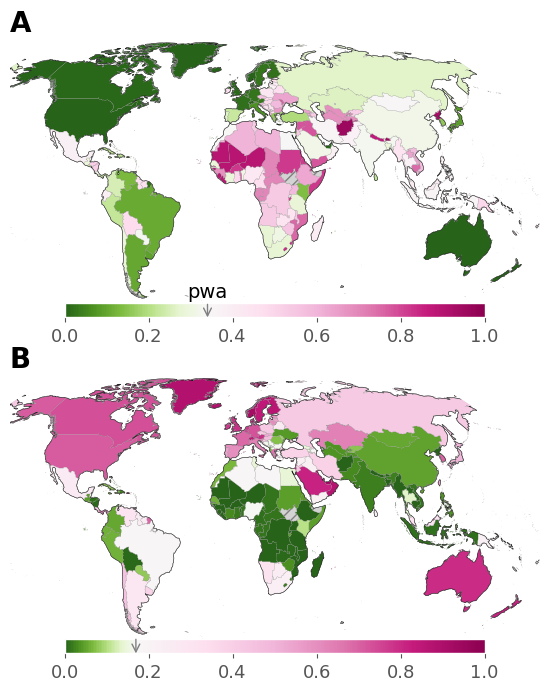

In [46]:
# Create a figure and a set of subplots
fig = plt.figure(figsize=(12, 8))
gs = gridspec.GridSpec(2, 1, wspace=0, hspace=0.2)

map_extent = [-135, 180, -60, 90]  # [lonmin, lonmax, latmin, latmax]

# Create subplots with Robinson projection
for i in range(2):
    ax = plt.subplot(gs[i], projection=ccrs.Robinson())
    title = ax.set_title(f"{string.ascii_uppercase[i]}", loc='left', pad=0, fontsize=20, fontweight='bold')

    # Plot the data

    df_shp_gtap.to_crs(ccrs.Robinson()).plot(
        linewidths=0, column=main_plot_columns_gtap[i], ax=ax, vmin=0, vmax=1, legend=False,
        cmap=main_color_gtap[i], missing_kwds={
            "color": "lightgrey",
            "edgecolor": "grey",
            "hatch": "///",
            "label": "Missing values",
        }
    )
    df_shp_gtap.to_crs(ccrs.Robinson()).boundary.plot(ax=ax, linewidth=0.1, edgecolor='grey')


    ax.set_extent(map_extent, crs=ccrs.PlateCarree())

    # Add coastlines and gridlines
    ax.coastlines(linewidths=0.4)
    plt.rcParams['axes.facecolor'] = 'white'
    ax.axis('off')

    # Add colorbar
    norm = colors.Normalize(vmin=0, vmax=1)
    sm = cm.ScalarMappable(cmap=main_color_gtap[i], norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax, orientation='horizontal', pad=-0.01, aspect=30, fraction=0.05)
    cbar.ax.tick_params(labelsize=13)

    # Add marker on colorbar
    avg_value = main_avg_value_gtap[i]  # Assuming white color corresponds to the mid-point (0.5)
    if i == 0:
      cbar.ax.annotate(
      'pwa',
      xy=(avg_value, -1),
      xytext=(avg_value, 1.8),
      xycoords='axes fraction',
      ha='center',
      va='center',
      fontsize=14,
      arrowprops=dict(facecolor='red',edgecolor='grey', arrowstyle='->', shrinkA=0, shrinkB=10, lw=1))
    else:
      cbar.ax.annotate(
      '',
      xy=(avg_value, -1),
      xytext=(avg_value, 1),
      xycoords='axes fraction',
      ha='center',
      va='center',
      fontsize=14,
      arrowprops=dict(facecolor='red', edgecolor='grey',arrowstyle='->', shrinkA=0, shrinkB=10, lw=1))




# fig.text(0.5, 0.03, 'Fraction of domestic (A) and foreign (B) deaths caused by foreign (A) and domestic (B) demand', ha='center', fontsize=12)

plt.subplots_adjust(wspace=0, hspace=0.1)

# Save the figure as a PDF
plt.savefig("First_review_plot/Fig3_GTAP.pdf", format='pdf', dpi=300, bbox_inches='tight')
plt.show()


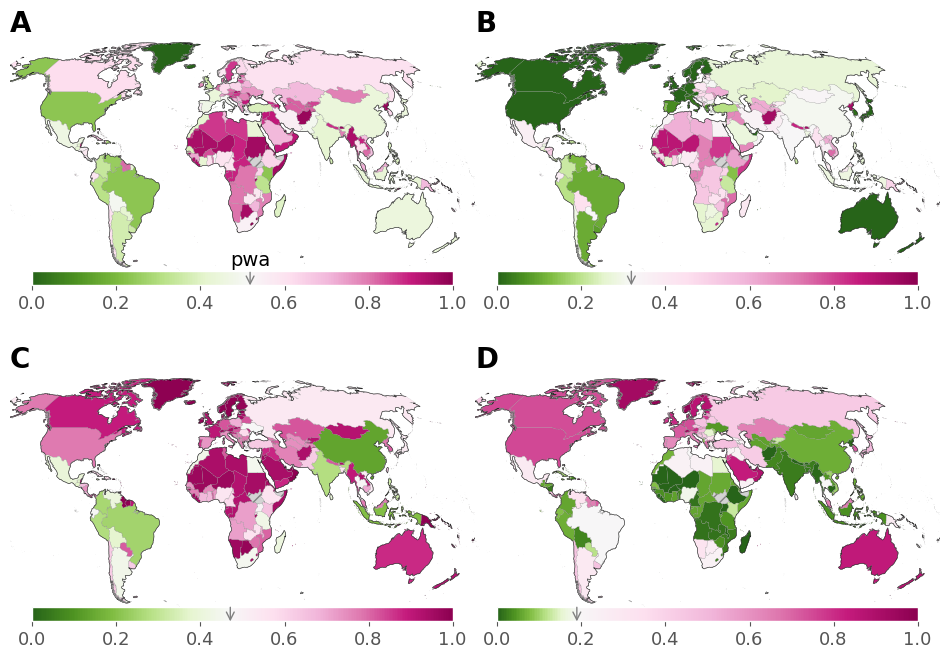

In [47]:
# Create a figure and a set of subplots
fig = plt.figure(figsize=(12, 8))
gs = gridspec.GridSpec(2, 2, wspace=0, hspace=0.2)

map_extent = [-135, 180, -60, 90]  # [lonmin, lonmax, latmin, latmax]

# Create subplots with Robinson projection
for i in range(4):
    ax = plt.subplot(gs[i], projection=ccrs.Robinson())
    title = ax.set_title(f"{string.ascii_uppercase[i]}", loc='left', pad=0, fontsize=20, fontweight='bold')

    # Plot the data

    df_shp_gtap.to_crs(ccrs.Robinson()).plot(
        linewidths=0, column=sup_plot_columns_gtap[i], ax=ax, vmin=0, vmax=1, legend=False,
        cmap=sup_color_gtap[i], missing_kwds={
            "color": "lightgrey",
            "edgecolor": "grey",
            "hatch": "///",
            "label": "Missing values",
        }
    )
    df_shp_gtap.to_crs(ccrs.Robinson()).boundary.plot(ax=ax, linewidth=0.1, edgecolor='grey')
    ax.set_extent(map_extent, crs=ccrs.PlateCarree())

    # Add coastlines and gridlines
    ax.coastlines(linewidths=0.4)
    plt.rcParams['axes.facecolor'] = 'white'
    ax.axis('off')

    # Add colorbar
    norm = colors.Normalize(vmin=0, vmax=1)
    sm = cm.ScalarMappable(cmap=sup_color_gtap[i], norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax, orientation='horizontal', pad=-0.01, aspect=30, fraction=0.05)
    cbar.ax.tick_params(labelsize=13)


    # Add marker on colorbar
    avg_value = sup_avg_value_gtap[i]  # Assuming white color corresponds to the mid-point (0.5)
    if i == 0:
      cbar.ax.annotate(
      'pwa',
      xy=(avg_value, -1),
      xytext=(avg_value, 1.8),
      xycoords='axes fraction',
      ha='center',
      va='center',
      fontsize=14,
      arrowprops=dict(facecolor='red',edgecolor='grey', arrowstyle='->', shrinkA=0, shrinkB=10, lw=1))
    else:
      cbar.ax.annotate(
      '',
      xy=(avg_value, -1),
      xytext=(avg_value, 1),
      xycoords='axes fraction',
      ha='center',
      va='center',
      fontsize=14,
      arrowprops=dict(facecolor='red', edgecolor='grey',arrowstyle='->', shrinkA=0, shrinkB=10, lw=1))


# fig.text(0.5, 0.03, 'Fraction of domestic (A,B) and foreign (C,D) deaths caused by foreign (A,B) and domestic (C,D) demand', ha='center', fontsize=12)

plt.subplots_adjust(wspace=0, hspace=0.1)

# Save the figure as a PDF
plt.savefig("First_review_plot/Fig3_GTAP2.pdf", format='pdf', dpi=300, bbox_inches='tight')
plt.show()


In [48]:
pwa_allforeign_world_gtap,pwa_G50foreign_world_gtap,pwa_G100foreign_world_gtap,pwa_cause_allforeign_world_gtap,pwa_cause_G30foreign_world_gtap,pwa_cause_G50foreign_world_gtap

(np.float64(0.5181140338885313),
 np.float64(0.34017973029886894),
 np.float64(0.31871347100977654),
 np.float64(0.47094227346996115),
 np.float64(0.18891062941154527),
 np.float64(0.16969038164694625))

# EORA

In [49]:
#@title Read files

# We only care about the country sequence
file = open("Data/Total_pop.json", "r")
population2 = file.read()
population2 = json.loads(population2)
Countries = list(population2.keys())

# population
file = open("First_review_data/Total_pop_eora.json", "r")
population_eora = file.read()
population_eora = json.loads(population_eora)
population_eora = {k: population_eora[k] for k in Countries}

con_mort_tol_eora = pd.read_csv('First_review_data/S4.csv',index_col=0)
# Row sum: total deaths happen in that country
con_total_eora = dict(con_mort_tol_eora.sum(axis=1))

# Col sum: total deaths caused by that country
con_caused_eora = dict(con_mort_tol_eora.sum(axis=0))

file = open("Data/final_demand_eora.json", "r")
final_demand_eora = file.read()
final_demand_eora = json.loads(final_demand_eora)

# EORA is in 1000 USD
for i in final_demand_eora:
    final_demand_eora[i] = final_demand_eora[i] * 1000

gdp_eora = final_demand_eora
gdp_eora = {k: gdp_eora[k] for k in Countries}


file = open("Data/final_demand_eora.json", "r")
final_demand_eora = file.read()
final_demand_eora = json.loads(final_demand_eora)

# eora is in 1000000 USD
for i in final_demand_eora:
    final_demand_eora[i] = final_demand_eora[i] * 1000000

demand_capita_eora = {}
for country in population_eora:
    if population_eora[country] == 0:
        demand_capita_eora[country] = 0
    else:
        demand_capita_eora[country] = final_demand_eora[country] / population_eora[country]

In [50]:
#@title 2.1 Calculation 1: Fraction of deaths caused by foreign demand and occur in the current country
# deaths happen in that country caused by foreign demand
death_by_allforeigndemand_eora = {} # deaths caused by all foreign demand
death_by_G50foreigndemand_eora = {} # deaths caused by demand from countries where demand/capita is >50% more than demand/capita in current country
death_by_G100foreigndemand_eora = {} # deaths caused by demand from countries where demand/capita is >100% more than demand/capita in current country
for i in demand_capita_eora:
    death_by_allforeigndemand_eora[i] = 0
    death_by_G50foreigndemand_eora[i] = 0
    death_by_G100foreigndemand_eora[i] = 0
    for j in demand_capita_eora:
        if i != j:
            death_by_allforeigndemand_eora[i] += con_mort_tol_eora[j][i] # deaths caused by j and happen in i

            if demand_capita_eora[j] >= 1.5 * demand_capita_eora[i]:
                death_by_G50foreigndemand_eora[i] += con_mort_tol_eora[j][i]

            if demand_capita_eora[j] >= 2 * demand_capita_eora[i]:
                death_by_G100foreigndemand_eora[i] += con_mort_tol_eora[j][i]

# total deaths happen in that country
con_dom_world_eora = {}
for country in con_mort_tol_eora:
    con_dom_world_eora[country] = {}
    con_dom_world_eora[country]['domestic'] = con_mort_tol_eora[country][country]
    con_dom_world_eora[country]['world'] = con_total_eora[country]
    con_dom_world_eora[country]['OtherPartofWorld'] = con_dom_world_eora[country]['world'] - con_dom_world_eora[country]['domestic']

# total deaths happen in that country RATIO
allforeign_world_eora = {}
G50foreign_world_eora = {}
G100foreign_world_eora = {}
for country in con_dom_world_eora:
    if con_dom_world_eora[country]['world'] != 0:
        allforeign_world_eora[country] = death_by_allforeigndemand_eora[country] / con_dom_world_eora[country]['world']
        G50foreign_world_eora[country] = death_by_G50foreigndemand_eora[country] / con_dom_world_eora[country]['world']
        G100foreign_world_eora[country] = death_by_G100foreigndemand_eora[country] / con_dom_world_eora[country]['world']
    else:
        allforeign_world_eora[country] = 0
        G50foreign_world_eora[country] = 0
        G100foreign_world_eora[country] = 0

In [51]:
# Pololation weighted average for Fraction of deaths caused by foreign demand and occur in the current country
pwa_allforeign_world_eora = 0
pwa_G50foreign_world_eora = 0
pwa_G100foreign_world_eora = 0

for country in population_eora:
  pwa_allforeign_world_eora += population_eora[country] * allforeign_world_eora[country]
  pwa_G50foreign_world_eora += population_eora[country] * G50foreign_world_eora[country]
  pwa_G100foreign_world_eora += population_eora[country] * G100foreign_world_eora[country]

pwa_allforeign_world_eora = pwa_allforeign_world_eora / dictsum(population_eora)
pwa_G50foreign_world_eora = pwa_G50foreign_world_eora / dictsum(population_eora)
pwa_G100foreign_world_eora = pwa_G100foreign_world_eora / dictsum(population_eora)
pwa_allforeign_world_eora,pwa_G50foreign_world_eora,pwa_G100foreign_world_eora

(np.float64(0.44433085333726086),
 np.float64(0.2838724544456288),
 np.float64(0.2632934380652837))

In [52]:
#@title 2.2 Calculation 2: Fraction of deaths caused by consumption in this country that occur in other countries
# deaths caused by this country and happen in foreign country
death_allforeign_eora = {} # deaths caused by consumption in this country that occur in ALL other countries
death_L30foreigndemand_eora = {} # deaths caused by consumption in this country that occur in countries with >33% lower demand/capita than the current country
death_L50foreigndemand_eora = {} # deaths caused by consumption in this country that occur in countries with >50% lower demand/capita than the current country

for i in con_mort_tol_eora:
    death_allforeign_eora[i] = 0
    death_L30foreigndemand_eora[i] = 0
    death_L50foreigndemand_eora[i] = 0
    for j in con_mort_tol_eora:
        if i != j:
            death_allforeign_eora[i] += con_mort_tol_eora[i][j] # deaths caused by i and happen in j

            if demand_capita_eora[j] <= 0.7 * demand_capita_eora[i]:
                death_L30foreigndemand_eora[i] += con_mort_tol_eora[i][j]

            if demand_capita_eora[j] <= 0.5 * demand_capita_eora[i]:
                death_L50foreigndemand_eora[i] += con_mort_tol_eora[i][j]

# total deaths caused by that country
con_cause_dom_world_eora = {}
for country in con_mort_tol_eora:
    con_cause_dom_world_eora[country] = {}
    con_cause_dom_world_eora[country]['domestic'] = con_mort_tol_eora[country][country]
    con_cause_dom_world_eora[country]['world'] = con_caused_eora[country]
    con_cause_dom_world_eora[country]['OtherPartofWorld'] = con_cause_dom_world_eora[country]['world'] - con_cause_dom_world_eora[country]['domestic']

# total deaths caused by that country RATIO
cause_allforeign_world_eora = {}
cause_L30foreign_world_eora = {}
cause_L50foreign_world_eora = {}
for country in con_cause_dom_world_eora:
    if con_cause_dom_world_eora[country]['world'] != 0:
        cause_allforeign_world_eora[country] = death_allforeign_eora[country] / con_cause_dom_world_eora[country]['world']
        cause_L30foreign_world_eora[country] = death_L30foreigndemand_eora[country] / con_cause_dom_world_eora[country]['world']
        cause_L50foreign_world_eora[country] = death_L50foreigndemand_eora[country] / con_cause_dom_world_eora[country]['world']
    else:
        cause_allforeign_world_eora[country] = 0
        cause_L30foreign_world_eora[country] = 0
        cause_L50foreign_world_eora[country] = 0

In [53]:
total_Deaths_eora = {"ROW": 70204.51148529616, "NZL": 620.5711425131341, "FJI": 0.0, "FRA": 14721.832394553823, "USA": 105261.18422699833, "RUS": 88131.4512973386, "WSM": 0.0, "PYF": 7.94825505044681, "CAN": 10240.819048091744, "GBR": 9396.253553759201, "MEX": 73936.17737794969, "CHL": 9750.895264313149, "ECU": 9035.206281431916, "GTM": 8245.869921402871, "CRI": 1178.6339945693453, "SLV": 3664.390197533475, "BLZ": 12.674648261714163, "HND": 1951.343185452918, "NIC": 543.4387139650923, "CUB": 5252.462987738359, "PER": 19652.72421581511, "COL": 24124.152222640496, "PAN": 1114.1632621867184, "CYM": 37.03056414437579, "JAM": 1934.7181431821912, "BHS": 68.49091062633414, "HTI": 10244.395583110208, "BRA": 109011.46479447998, "ARG": 19006.093096926772, "DOM": 4774.4040034733, "VEN": 11941.673837801594, "GRL": 0.0, "NLD": 7403.1758162272545, "ABW": 4.269121367057958, "BOL": 4297.334113637834, "VGB": 0.0, "BMU": 5.572981812929262, "PRY": 1017.9421812510457, "ATG": 0.0, "DNK": 1633.6109157025837, "TTO": 363.0146426128124, "GUY": 35.65906677556587, "BRB": 54.95334413336108, "SUR": 91.01542305335391, "URY": 1431.2798878361916, "PRT": 3712.0366773933733, "ISL": 0.0, "CPV": 272.6078399074461, "SEN": 9537.154526822194, "ESP": 29281.559975460437, "GMB": 1091.546046294521, "MRT": 2630.307112229899, "GIN": 5436.554685310942, "SLE": 1607.6072038612954, "IRL": 162.34147099093434, "MAR": 23207.737286571897, "LBR": 454.80255593507, "NOR": 58.925712683789115, "MLI": 10907.431411364974, "CIV": 4069.9355125210077, "DZA": 17434.365609232693, "BFA": 11633.76911567298, "GHA": 7870.686551750323, "TGO": 2588.552443036407, "NER": 11638.6568916605, "BEN": 3677.8134600870867, "AND": 15.111229332318283, "BEL": 5215.497236015623, "STP": 45.314578400851154, "NGA": 87501.55057033192, "DEU": 41597.872650507736, "LUX": 114.98888268325271, "CHE": 1566.7057313708578, "GAB": 1190.3944600451405, "ITA": 46704.60199315207, "TUN": 7652.210451304564, "MCO": 41.86497167108914, "NAM": 1078.0094790220812, "AGO": 16050.723285782444, "COG": 1354.1500084461888, "COD": 37337.01534989838, "LBY": 4079.733661925696, "CMR": 9266.024985200773, "LIE": 5.394510217638608, "AUT": 3501.2650925113517, "SWE": 570.493684863716, "CZE": 7003.578513213999, "SMR": 2.9878448440619882, "ZAF": 47032.29181662315, "TCD": 10479.491083766077, "MLT": 306.4105449946623, "SVN": 1023.1349790861561, "HRV": 3248.237365032071, "POL": 25250.820008316812, "CAF": 2978.851974386617, "BIH": 3116.4869719419967, "HUN": 8809.073162448589, "SVK": 3373.2303309293866, "GRC": 16291.051073061817, "ALB": 1930.1399099146151, "MNE": 626.7405885172706, "SRB": 10414.665294149618, "BWA": 851.3462181890081, "LTU": 768.9457980568957, "FIN": 243.80194495684106, "ROU": 32007.594453302598, "LVA": 334.9061591138249, "MKD": 2346.224654402728, "EST": 89.21809511906322, "ZMB": 6569.765182341395, "SUD": 26314.38572409932, "UKR": 35140.85055974009, "BGR": 11968.45333992715, "EGY": 66852.38712873451, "BLR": 3960.0670569164276, "SDS": 8950.520107411372, "ZWE": 3588.252736048059, "TUR": 57973.32871158527, "MDA": 2219.1476733732907, "LSO": 1016.1354860064494, "CYP": 887.5562341045584, "RWA": 3260.3840965583813, "BDI": 2182.013881437059, "TZA": 10143.743022971517, "UGA": 11826.773303290505, "MOZ": 6347.1609512276555, "SWZ": 892.2464452742132, "MWI": 3263.1727944786107, "ETH": 36357.90169863065, "ISR": 4788.763054032042, "LBN": 8313.28846281984, "KEN": 9400.006202092858, "PSE": 1847.1767723412243, "SAU": 20633.033622603332, "JOR": 1793.159035780492, "SYR": 16126.995782956788, "ERI": 3361.970078390445, "IRQ": 16872.48756718864, "GEO": 4275.546536613425, "SOM": 2432.50743690007, "MDG": 2412.7175176264964, "DJI": 821.5912860726421, "YEM": 19949.21224646118, "SYC": 4.931233665660132, "ARM": 2804.74552793948, "IRN": 50699.31772054792, "AZE": 9365.418991937935, "KWT": 1042.111563068458, "KAZ": 9921.593717985015, "BHR": 872.5510734446095, "QAT": 1532.7460770446937, "OMN": 1740.0202646997145, "TKM": 6599.583471768791, "ARE": 2268.0307282799326, "MUS": 340.90550651252994, "UZB": 17825.213632443574, "AFG": 16953.294174241906, "PAK": 154118.8225570859, "IND": 947835.1523975696, "TJK": 2994.2630496039333, "AUS": 6443.369076254984, "MDV": 104.93010334876487, "KGZ": 3077.912204678187, "CHN": 1493905.938146951, "LKA": 15783.737632131806, "NPL": 24264.73844342149, "BGD": 79272.1738871578, "BTN": 420.17849719913, "MNG": 855.4639815308443, "MMR": 21320.829733558156, "IDN": 203110.3067645526, "THA": 49687.392861848784, "MYS": 18051.69379848547, "LAO": 2273.0429346033616, "KHM": 6667.246382994651, "VNM": 64376.37097886478, "SGP": 2915.156242961522, "BRN": 66.45412920854868, "PHL": 40679.57875357679, "MAC": 598.6426992053979, "TWN": 20126.332415825338, "HKG": 8428.127411947638, "JPN": 112288.19164698623, "PRK": 18856.10177917535, "KOR": 28857.227192561117, "PNG": 111.99316113790456, "NCL": 112.78900673108726, "VUT": 0.0}

In [54]:
dictsum(total_Deaths_eora)

5083412.66908163

In [55]:
dictsum(death_by_G50foreigndemand_eora)/dictsum(total_Deaths_eora),dictsum(death_L30foreigndemand_eora)/dictsum(total_Deaths_eora)

(np.float64(0.14173697541089825), np.float64(0.1431608758888721))

In [56]:
# Pololation weighted average for Fraction of deaths caused by foreign demand and occur in the current country
pwa_cause_allforeign_world_eora = 0
pwa_cause_G30foreign_world_eora = 0
pwa_cause_G50foreign_world_eora = 0

for country in population_eora:
  pwa_cause_allforeign_world_eora += population_eora[country] * cause_allforeign_world_eora[country]
  pwa_cause_G30foreign_world_eora += population_eora[country] * cause_L30foreign_world_eora[country]
  pwa_cause_G50foreign_world_eora += population_eora[country] * cause_L50foreign_world_eora[country]

pwa_cause_allforeign_world_eora = pwa_cause_allforeign_world_eora / dictsum(population_eora)
pwa_cause_G30foreign_world_eora = pwa_cause_G30foreign_world_eora / dictsum(population_eora)
pwa_cause_G50foreign_world_eora = pwa_cause_G50foreign_world_eora / dictsum(population_eora)
pwa_cause_allforeign_world_eora,pwa_cause_G30foreign_world_eora,pwa_cause_G50foreign_world_eora

(np.float64(0.4019478225068136),
 np.float64(0.16873288371746625),
 np.float64(0.14881449910296057))

In [57]:
poor_coun_import_death_eora = {}
for i in gdp_eora:
  if gdp_eora[i] / population_eora[i] < 10000: # countries with per capita GDP < 10000
    poor_coun_import_death_eora[i] = 0 # Count the number of deaths caused by wealthier countries
    for j in gdp_eora:
      if gdp_eora[j] / population_eora[j] >= 10000:
        poor_coun_import_death_eora[i] += con_mort_tol_eora[j][i] # The number of deaths caused by country j (country with per capita GDP greater than 10k) and happen in country i

poor_percent_eora = {}
for country in poor_coun_import_death_eora:
  if con_total_eora[country] != 0:
    poor_percent_eora[country] = poor_coun_import_death_eora[country] / con_total_eora[country]
  else:
    poor_percent_eora[country] = 0
  # The proportion of deaths in a poorer country attributable to wealthier countries' activities out of the total deaths in that poorer country.
# dict(sorted(poor_percent_eora.items(), key=lambda item: item[1]))

In [58]:
len({k: v for k, v in poor_percent_eora.items() if v > 0.2})/ len(poor_percent_eora), len(poor_percent_eora)

(0.6271186440677966, 118)

In [59]:
wealthy_coun_import_death_eora = {}
for i in gdp_eora:
  if gdp_eora[i] / population_eora[i] > 20000: # countries with per capita GDP > 20000
    wealthy_coun_import_death_eora[i] = 0 # Count the number of deaths happen in poorer countries
    for j in gdp_eora:
      if gdp_eora[j] / population_eora[j] < 10000:
        wealthy_coun_import_death_eora[i] += con_mort_tol_eora[i][j] # The number of deaths caused by country i (country with per capita GDP greater than 20k) and happen in country j

wealthy_percent_eora = {}
for country in wealthy_coun_import_death_eora:
  wealthy_percent_eora[country] = wealthy_coun_import_death_eora[country] / con_caused_eora[country]
  # The proportion of deaths in a poorer country caused by wealthier countries to the total number of deaths caused by these wealthier countries.
dict(sorted(wealthy_percent_eora.items(), key=lambda item: item[1]))

{'JPN': np.float64(0.35486440070328695),
 'BHS': np.float64(0.4655065730566277),
 'ESP': np.float64(0.5183183612389333),
 'ITA': np.float64(0.5236945083434908),
 'DEU': np.float64(0.5244292126660783),
 'CAN': np.float64(0.5587485950712583),
 'BEL': np.float64(0.5591598816441443),
 'KOR': np.float64(0.5670566872896746),
 'NCL': np.float64(0.5684414204687709),
 'LUX': np.float64(0.5791468049322596),
 'FRA': np.float64(0.5934284061493095),
 'AUT': np.float64(0.6284912490330614),
 'USA': np.float64(0.6633931137322863),
 'DNK': np.float64(0.6709412315656588),
 'GBR': np.float64(0.6722268335614373),
 'NLD': np.float64(0.67808954231324),
 'AUS': np.float64(0.6810751754938891),
 'AND': np.float64(0.6877641845903533),
 'CHE': np.float64(0.6889626153513744),
 'IRL': np.float64(0.6931886461516862),
 'ISL': np.float64(0.6951447892836207),
 'MLT': np.float64(0.7065771187688191),
 'GRL': np.float64(0.7140860988520195),
 'ISR': np.float64(0.719391250432219),
 'NZL': np.float64(0.7265742910041293),
 '

In [60]:
len({k: v for k, v in wealthy_percent_eora.items() if v > 0.5})/ len(wealthy_percent_eora), len(wealthy_percent_eora)

(0.9534883720930233, 43)

In [61]:
# @title 2.3 Ratio plot preparation for GTAP
df_shp_eora = gpd.read_file('Data/10m_cultural/ne_10m_admin_0_countries.shp')

df_shp_eora["allforeign_world"] = np.nan
df_shp_eora["G50foreign_world"] = np.nan
df_shp_eora["G100foreign_world"] = np.nan
df_shp_eora["cause_allforeign_world"] = np.nan
df_shp_eora["cause_L30foreign_world"] = np.nan
df_shp_eora["cause_L50foreign_world"] = np.nan
df_shp_eora["population"] = np.nan

for i in df_shp_eora['ADM0_A3']:
    if i in Countries:
        df_shp_eora.loc[df_shp_eora['ADM0_A3'] == i,"allforeign_world"] = allforeign_world_eora[i]
        df_shp_eora.loc[df_shp_eora['ADM0_A3'] == i,"G50foreign_world"] = G50foreign_world_eora[i]
        df_shp_eora.loc[df_shp_eora['ADM0_A3'] == i,"G100foreign_world"] = G100foreign_world_eora[i]
        df_shp_eora.loc[df_shp_eora['ADM0_A3'] == i,"cause_allforeign_world"] = cause_allforeign_world_eora[i]
        df_shp_eora.loc[df_shp_eora['ADM0_A3'] == i,"cause_L30foreign_world"] = cause_L30foreign_world_eora[i]
        df_shp_eora.loc[df_shp_eora['ADM0_A3'] == i,"cause_L50foreign_world"] = cause_L50foreign_world_eora[i]
        df_shp_eora.loc[df_shp_eora['ADM0_A3'] == i,"population"] = population_eora[i]


    if i == 'PSX':
        df_shp_eora.loc[df_shp_eora['ADM0_A3'] == i,"allforeign_world"] = allforeign_world_eora['PSE']
        df_shp_eora.loc[df_shp_eora['ADM0_A3'] == i,"G50foreign_world"] = G50foreign_world_eora['PSE']
        df_shp_eora.loc[df_shp_eora['ADM0_A3'] == i,"G100foreign_world"] = G100foreign_world_eora['PSE']
        df_shp_eora.loc[df_shp_eora['ADM0_A3'] == i,"cause_allforeign_world"] = cause_allforeign_world_eora['PSE']
        df_shp_eora.loc[df_shp_eora['ADM0_A3'] == i,"cause_L30foreign_world"] = cause_L30foreign_world_eora['PSE']
        df_shp_eora.loc[df_shp_eora['ADM0_A3'] == i,"cause_L50foreign_world"] = cause_L50foreign_world_eora['PSE']
        df_shp_eora.loc[df_shp_eora['ADM0_A3'] == i,"population"] = population_eora['PSE']


    if i == 'SDN':
        df_shp_eora.loc[df_shp_eora['ADM0_A3'] == i,"allforeign_world"] = allforeign_world_eora['SUD']
        df_shp_eora.loc[df_shp_eora['ADM0_A3'] == i,"G50foreign_world"] = G50foreign_world_eora['SUD']
        df_shp_eora.loc[df_shp_eora['ADM0_A3'] == i,"G100foreign_world"] = G100foreign_world_eora['SUD']
        df_shp_eora.loc[df_shp_eora['ADM0_A3'] == i,"cause_allforeign_world"] = cause_allforeign_world_eora['SUD']
        df_shp_eora.loc[df_shp_eora['ADM0_A3'] == i,"cause_L30foreign_world"] = cause_L30foreign_world_eora['SUD']
        df_shp_eora.loc[df_shp_eora['ADM0_A3'] == i,"cause_L50foreign_world"] = cause_L50foreign_world_eora['SUD']
        df_shp_eora.loc[df_shp_eora['ADM0_A3'] == i,"population"] = population_eora['SUD']

    if i == 'ROW':
        continue

In [62]:
Africa_eora = df_shp_eora[(df_shp_eora['CONTINENT'] == 'Africa') & (df_shp_eora['G50foreign_world'].notna())].reset_index()
Sahel_eora = df_shp_eora[(df_shp_eora.ADM0_A3.isin(Sahel_region)) & (df_shp_eora['G50foreign_world'].notna())].reset_index()
Middle_east_eora = df_shp_eora[(df_shp_eora.ADM0_A3.isin(Middle_east_region)) & (df_shp_eora['G50foreign_world'].notna())].reset_index()
Eastern_Europe_eora = df_shp_eora[(df_shp_eora.SUBREGION=='Eastern Europe') & (df_shp_eora['G50foreign_world'].notna())].reset_index()
Western_Europe_eora = df_shp_eora[(df_shp_eora.SUBREGION=='Western Europe') & (df_shp_eora['G50foreign_world'].notna())].reset_index()
North_America_eora = df_shp_eora[(df_shp_eora.CONTINENT=='North America') & (df_shp_eora['G50foreign_world'].notna())].reset_index()
South_American_eora = df_shp_eora[(df_shp_eora.CONTINENT=='South America') & (df_shp_eora['G50foreign_world'].notna())].reset_index()
Oceania_eora = df_shp_eora[(df_shp_eora.CONTINENT=='Oceania') & (df_shp_eora['G50foreign_world'].notna())].reset_index()

dfs_eora = [Africa_eora,Sahel_eora,Middle_east_eora,Eastern_Europe_eora,Western_Europe_eora,North_America_eora,South_American_eora,Oceania_eora]

results_eora = [population_averaged(df) for df in dfs_eora]

In [63]:
Oceania_eora

,index,featurecla,scalerank,LABELRANK,SOVEREIGNT,SOV_A3,ADM0_DIF,LEVEL,TYPE,ADMIN,...,NAME_VI,NAME_ZH,geometry,allforeign_world,G50foreign_world,G100foreign_world,cause_allforeign_world,cause_L30foreign_world,cause_L50foreign_world,population
0,159,Admin-0 country,0,2,Papua New Guinea,PNG,0,2,Sovereign country,Papua New Guinea,...,Papua New Guinea,巴布亚新几内亚,"MULTIPOLYGON (((140.97446 -2.60052, 140.98732 ...",0.390037,0.372363,0.360781,0.923519,0.053903,0.049119,8.789052e+06
1,173,Admin-0 country,0,2,Australia,AU1,1,2,Country,Australia,...,Úc,澳大利亚,"MULTIPOLYGON (((131.5359 -31.60556, 131.34555 ...",0.362299,0.000171,0.000094,0.786098,0.763098,0.722671,2.059677e+07
2,175,Admin-0 country,5,6,Fiji,FJI,0,2,Sovereign country,Fiji,...,Fiji,斐濟,"MULTIPOLYGON (((-180 -16.16961, -180 -16.14911...",0.000000,0.000000,0.000000,1.000000,0.894129,0.891456,1.067197e+05
3,176,Admin-0 country,6,2,New Zealand,NZ1,1,2,Country,New Zealand,...,New Zealand,新西兰,"MULTIPOLYGON (((166.13697 -50.86435, 166.20525...",0.496782,0.000315,0.000159,0.879197,0.831694,0.773081,3.096796e+06
4,177,Admin-0 country,6,3,France,FR1,1,2,Dependency,New Caledonia,...,Nouvelle-Calédonie,新喀里多尼亞,"MULTIPOLYGON (((163.98512 -20.04762, 163.98609...",0.644377,0.219545,0.011577,0.719171,0.597632,0.592283,2.993032e+05
5,190,Admin-0 country,6,4,France,FR1,1,2,Dependency,French Polynesia,...,Polynésie thuộc Pháp,法屬玻里尼西亞,"MULTIPOLYGON (((-136.16576 -22.02435, -136.175...",0.620480,0.500533,0.461263,0.949274,0.786117,0.733119,3.096421e+05
6,232,Admin-0 country,3,4,Samoa,WSM,0,2,Sovereign country,Samoa,...,Samoa,萨摩亚,"MULTIPOLYGON (((-172.20104 -13.59254, -172.197...",0.000000,0.000000,0.000000,1.000000,0.393233,0.321784,2.476890e+05
7,240,Admin-0 country,5,4,Vanuatu,VUT,0,2,Sovereign country,Vanuatu,...,Vanuatu,萬那杜,"MULTIPOLYGON (((169.84034 -20.1408, 169.86052 ...",0.000000,0.000000,0.000000,1.000000,0.146037,0.099928,2.838321e+05


In [64]:
for i in range(len(results_gtap)):
  print(results_gtap[i],results_eora[i])

0.6502349219708108 0.4341572477325792
0.7175892680193389 0.4188629002521236
0.6805519887425269 0.41374914071076485
0.41803474478706193 0.37992008063392135
0.049435434807223934 0.05081383063686498
0.16726101496786233 0.1214421850782999
0.1715987188651115 0.169223295347684
0.4499370132397638 0.10370402915666325


In [65]:
shifted_cmap1_eora = shiftedColorMap(matplotlib.cm.PiYG.reversed(), midpoint=pwa_allforeign_world_eora, name='shifted1_eora')
shifted_cmap2_eora = shiftedColorMap(matplotlib.cm.PiYG.reversed(), midpoint=pwa_G50foreign_world_eora, name='shifted2_eora')
shifted_cmap3_eora = shiftedColorMap(matplotlib.cm.PiYG.reversed(), midpoint=pwa_G100foreign_world_eora, name='shifted3_eora')
shifted_cmap4_eora = shiftedColorMap(matplotlib.cm.PiYG.reversed(), midpoint=pwa_cause_allforeign_world_eora, name='shifted4_eora')
shifted_cmap5_eora = shiftedColorMap(matplotlib.cm.PiYG.reversed(), midpoint=pwa_cause_G30foreign_world_eora, name='shifted5_eora')
shifted_cmap6_eora = shiftedColorMap(matplotlib.cm.PiYG.reversed(), midpoint=pwa_cause_G50foreign_world_eora, name='shifted6_eora')

In [66]:
plot_columns_eora = ['allforeign_world','G50foreign_world','G100foreign_world','cause_allforeign_world','cause_L30foreign_world','cause_L50foreign_world']
avg_value_eora = [pwa_allforeign_world_eora,pwa_G50foreign_world_eora,pwa_G100foreign_world_eora,pwa_cause_allforeign_world_eora,pwa_cause_G30foreign_world_eora,pwa_cause_G50foreign_world_eora]
color_eora = [shifted_cmap1_eora,shifted_cmap2_eora,shifted_cmap3_eora,shifted_cmap4_eora,shifted_cmap5_eora,shifted_cmap6_eora]

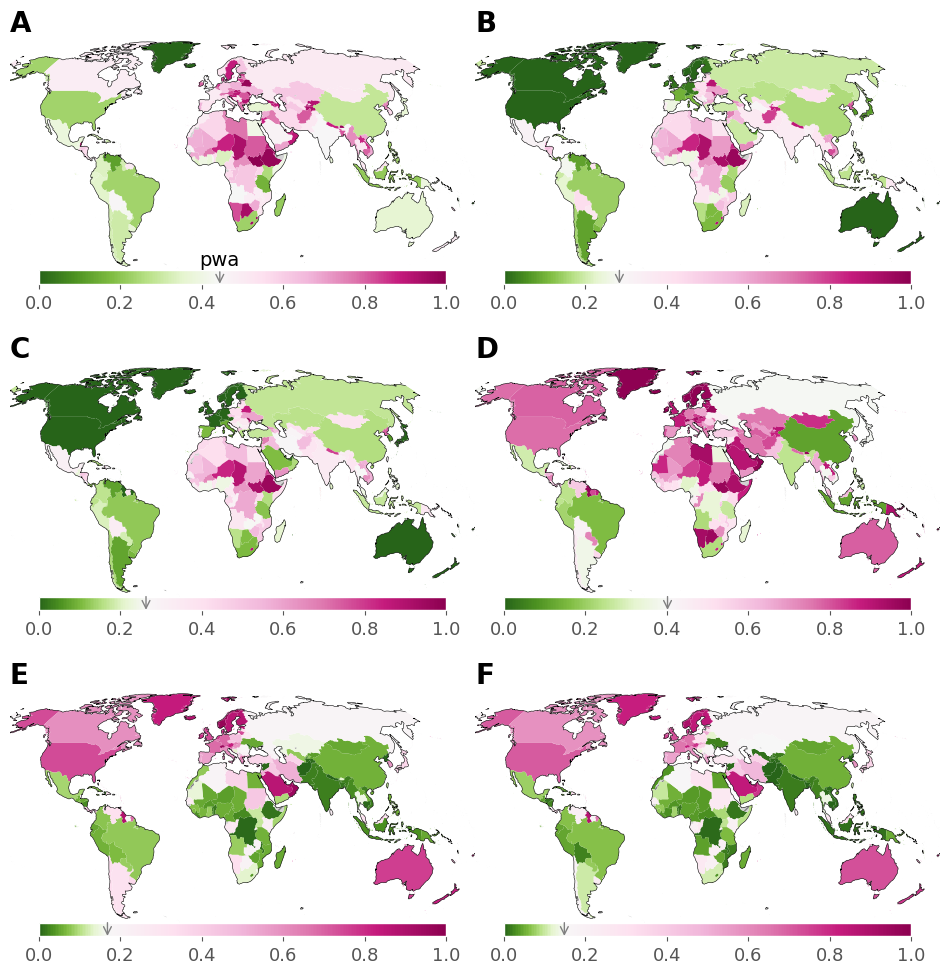

In [67]:
# Create a figure and a set of subplots
fig = plt.figure(figsize=(12, 12))
gs = gridspec.GridSpec(3, 2, wspace=0, hspace=0.2)

map_extent = [-135, 180, -60, 90]  # [lonmin, lonmax, latmin, latmax]

# Create subplots with Robinson projection
for i in range(6):
    ax = plt.subplot(gs[i], projection=ccrs.Robinson())
    title = ax.set_title(f"{string.ascii_uppercase[i]}", loc='left', pad=0, fontsize=20, fontweight='bold')

    # Plot the data

    df_shp_eora.to_crs(ccrs.Robinson()).plot(
        linewidths=0, column=plot_columns_eora[i], ax=ax, vmin=0, vmax=1, legend=False,
        cmap=color_eora[i], missing_kwds={
            "color": "lightgrey",
            "edgecolor": "grey",
            "hatch": "///",
            "label": "Missing values",
        }
    )
    ax.set_extent(map_extent, crs=ccrs.PlateCarree())

    # Add coastlines and gridlines
    ax.coastlines(linewidths=0.4)
    plt.rcParams['axes.facecolor'] = 'white'
    ax.axis('off')

    # Add colorbar
    norm = colors.Normalize(vmin=0, vmax=1)
    sm = cm.ScalarMappable(cmap=color_eora[i], norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax, orientation='horizontal', pad=-0.01, aspect=30, fraction=0.05)
    cbar.ax.tick_params(labelsize=13)


    # Add marker on colorbar
    avg_value = avg_value_eora[i]  # Assuming white color corresponds to the mid-point (0.5)
    if i == 0:
      cbar.ax.annotate(
      'pwa',
      xy=(avg_value, -1),
      xytext=(avg_value, 1.8),
      xycoords='axes fraction',
      ha='center',
      va='center',
      fontsize=14,
      arrowprops=dict(facecolor='red',edgecolor='grey', arrowstyle='->', shrinkA=0, shrinkB=10, lw=1))
    else:
      cbar.ax.annotate(
      '',
      xy=(avg_value, -1),
      xytext=(avg_value, 1),
      xycoords='axes fraction',
      ha='center',
      va='center',
      fontsize=14,
      arrowprops=dict(facecolor='red', edgecolor='grey',arrowstyle='->', shrinkA=0, shrinkB=10, lw=1))


# fig.text(0.5, 0.07, 'Fraction of domestic (A,B,C) and foreign (D,E,F) deaths caused by foreign (A,B,C) and domestic (D,E,F) demand', ha='center', fontsize=12)

plt.subplots_adjust(wspace=-0.5, hspace=-0.01)

# Save the figure as a PDF
plt.savefig("First_review_plot/Fig3_EORA.pdf", format='pdf', dpi=300, bbox_inches='tight')
plt.show()


In [68]:
pwa_allforeign_world_eora,pwa_G50foreign_world_eora,pwa_G100foreign_world_eora,pwa_cause_allforeign_world_eora,pwa_cause_G30foreign_world_eora,pwa_cause_G50foreign_world_eora

(np.float64(0.44433085333726086),
 np.float64(0.2838724544456288),
 np.float64(0.2632934380652837),
 np.float64(0.4019478225068136),
 np.float64(0.16873288371746625),
 np.float64(0.14881449910296057))

In [69]:
df_shp_gtap_new = df_shp_gtap[df_shp_gtap['allforeign_world'].notna()].reset_index()
df_shp_eora_new = df_shp_eora[df_shp_eora['allforeign_world'].notna()].reset_index()

In [70]:
pwa_G50foreign_world_gtap, pwa_cause_G50foreign_world_gtap

(np.float64(0.34017973029886894), np.float64(0.16969038164694625))

In [71]:
count = 0
country_pink = []
for i in range(len(df_shp_gtap_new)):
  country = df_shp_gtap_new.iloc[i]['ADM0_A3']
  G50 = df_shp_gtap_new.iloc[i]['G50foreign_world']
  cause_L50 = df_shp_gtap_new.iloc[i]['cause_L50foreign_world']
  if G50 > pwa_G50foreign_world_gtap and cause_L50 > pwa_cause_G50foreign_world_gtap:
    count += 1
    country_pink.append(country)

In [72]:
count

51

In [73]:
count = 0
country_green = []
for i in range(len(df_shp_gtap_new)):
  country = df_shp_gtap_new.iloc[i]['ADM0_A3']
  G50 = df_shp_gtap_new.iloc[i]['G50foreign_world']
  cause_L50 = df_shp_gtap_new.iloc[i]['cause_L50foreign_world']
  if G50 < pwa_G50foreign_world_gtap and cause_L50 < pwa_cause_G50foreign_world_gtap:
    count += 1
    country_green.append(country)

<Axes: >

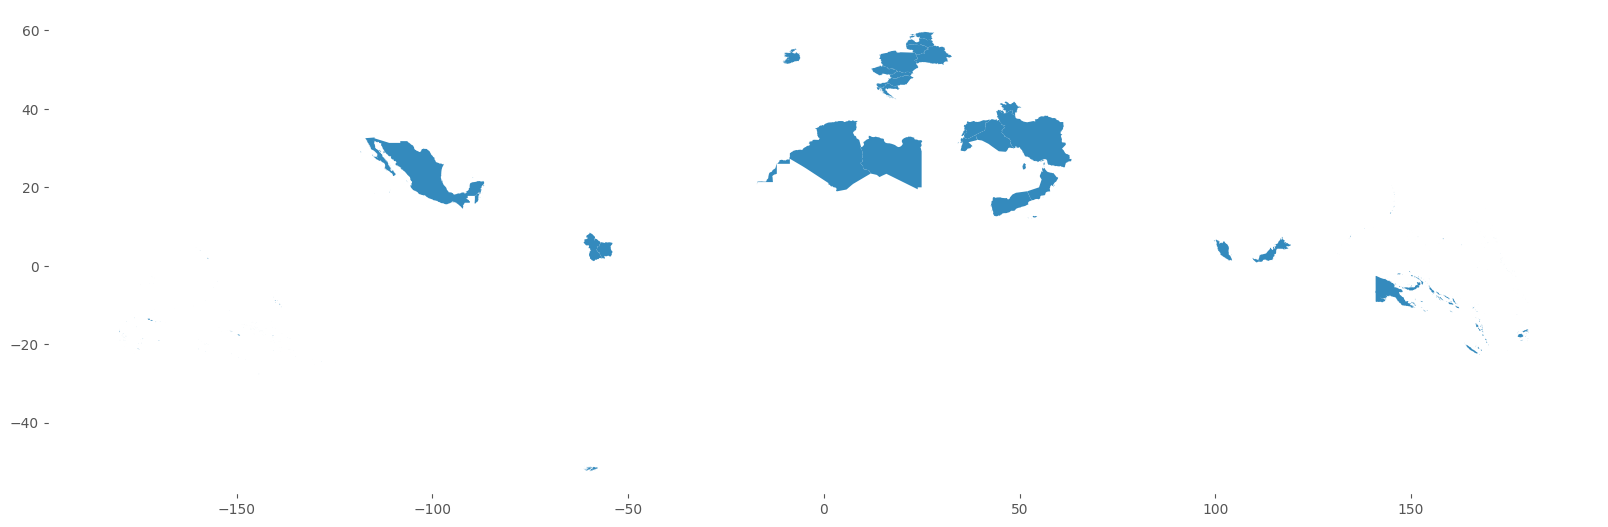

In [74]:
df_shp_gtap_new[df_shp_gtap_new['ADM0_A3'].isin(country_pink)].plot()

In [75]:
df_shp_gtap_new[df_shp_gtap_new['ADM0_A3'].isin(country_pink)]

,index,featurecla,scalerank,LABELRANK,SOVEREIGNT,SOV_A3,ADM0_DIF,LEVEL,TYPE,ADMIN,...,NAME_ZH,geometry,allforeign_world,G50foreign_world,G100foreign_world,cause_allforeign_world,cause_L30foreign_world,cause_L50foreign_world,gdp_per_capita,population
1,1,Admin-0 country,5,3,Malaysia,MYS,0,2,Sovereign country,Malaysia,...,马来西亚,"MULTIPOLYGON (((117.70361 4.16341, 117.69711 4...",0.718277,0.406666,0.382590,0.777212,0.656160,0.298176,9678.042752,3.493516e+07
10,11,Admin-0 country,0,5,Israel,IS1,1,2,Disputed,Palestine,...,巴勒斯坦,"MULTIPOLYGON (((34.4812 31.58314, 34.51141 31....",0.908586,0.778569,0.680321,0.876993,0.231038,0.218934,2992.119168,1.180665e+08
11,12,Admin-0 country,0,5,Lebanon,LBN,0,2,Sovereign country,Lebanon,...,黎巴嫩,"POLYGON ((35.10524 33.08902, 35.10524 33.09064...",0.908586,0.778569,0.680321,0.876993,0.231038,0.218934,2992.119168,1.180665e+08
18,20,Admin-0 country,0,3,Syria,SYR,0,2,Sovereign country,Syria,...,叙利亚,"POLYGON ((35.75759 32.74435, 35.7842 32.77795,...",0.908586,0.778569,0.680321,0.876993,0.231038,0.218934,2992.119168,1.180665e+08
20,23,Admin-0 country,0,4,Suriname,SUR,0,2,Sovereign country,Suriname,...,蘇利南,"POLYGON ((-54.0808 3.30931, -54.11429 3.28538,...",0.815196,0.453660,0.402053,0.998368,0.649479,0.244196,9456.690438,1.434857e+06
21,24,Admin-0 country,0,4,Guyana,GUY,0,2,Sovereign country,Guyana,...,圭亚那,"MULTIPOLYGON (((-56.48182 1.94161, -56.52851 1...",0.815196,0.453660,0.402053,0.998368,0.649479,0.244196,9456.690438,1.434857e+06
25,28,Admin-0 country,0,7,Western Sahara,SAH,0,2,Indeterminate,Western Sahara,...,西撒哈拉,"POLYGON ((-8.81703 27.66146, -8.81654 27.66147...",0.870851,0.604148,0.598969,0.939850,0.229761,0.187088,5025.735006,5.110894e+07
32,35,Admin-0 country,0,4,Belarus,BLR,0,2,Sovereign country,Belarus,...,白罗斯,"POLYGON ((23.60624 51.5174, 23.60231 51.53078,...",0.707732,0.465498,0.312847,0.823785,0.430589,0.254441,8271.594941,9.200523e+06
35,40,Admin-0 country,0,4,Oman,OMN,0,2,Sovereign country,Oman,...,阿曼,"MULTIPOLYGON (((56.26062 25.33108, 56.29069 25...",0.915339,0.379924,0.335909,0.992514,0.886953,0.874368,20250.456281,4.039267e+06
39,44,Admin-0 country,0,5,Lithuania,LTU,0,2,Sovereign country,Lithuania,...,立陶宛,"MULTIPOLYGON (((26.59453 55.66699, 26.60383 55...",0.845374,0.385196,0.338387,0.950490,0.779363,0.599117,17506.719386,2.762025e+06


<Axes: >

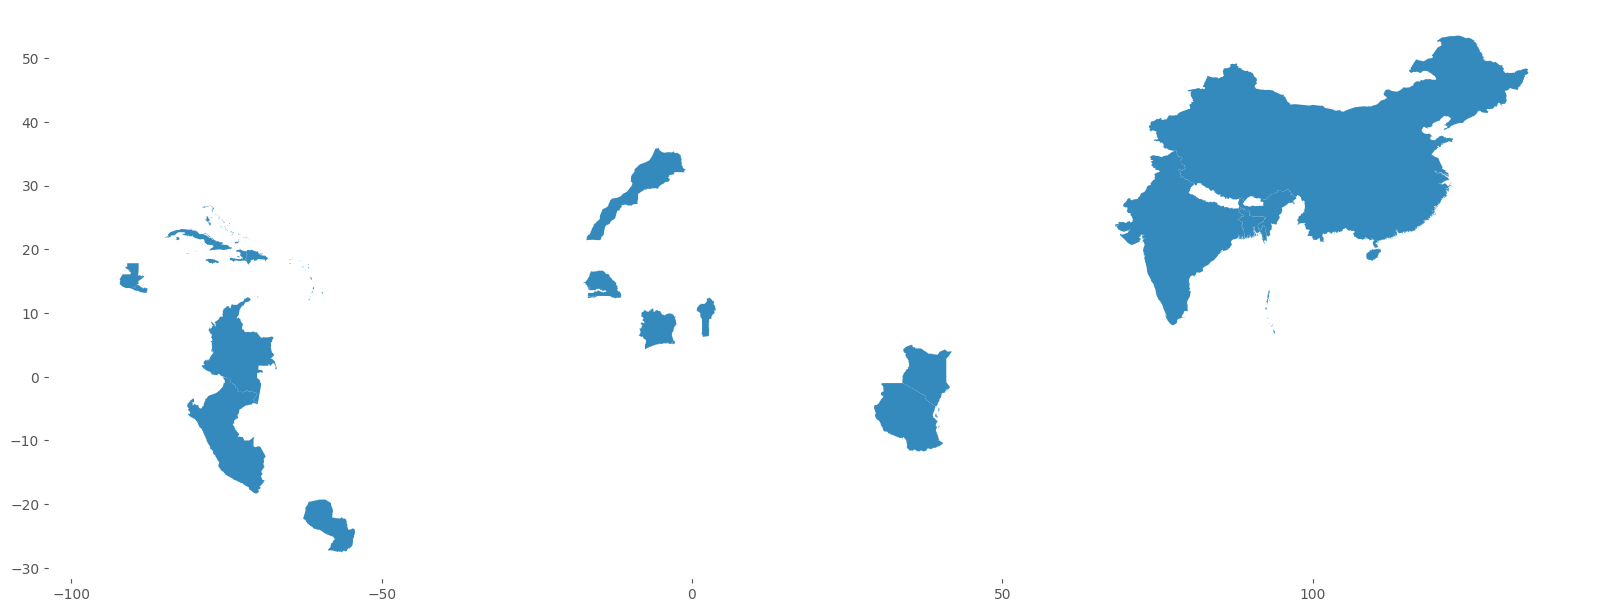

In [76]:
df_shp_gtap_new[df_shp_gtap_new['ADM0_A3'].isin(country_green)].plot()

In [77]:
df_shp_gtap_new[df_shp_gtap_new['ADM0_A3'].isin(country_green)]

,index,featurecla,scalerank,LABELRANK,SOVEREIGNT,SOV_A3,ADM0_DIF,LEVEL,TYPE,ADMIN,...,NAME_ZH,geometry,allforeign_world,G50foreign_world,G100foreign_world,cause_allforeign_world,cause_L30foreign_world,cause_L50foreign_world,gdp_per_capita,population
4,4,Admin-0 country,0,2,Peru,PER,0,2,Sovereign country,Peru,...,秘鲁,"MULTIPOLYGON (((-69.51009 -17.50659, -69.63832...",0.314627,0.219814,0.194292,0.272656,0.064608,0.058931,5658.986881,3.584652e+07
7,8,Admin-0 country,0,2,India,IND,0,2,Sovereign country,India,...,印度,"MULTIPOLYGON (((77.80035 35.49541, 77.81533 35...",0.419879,0.325652,0.320537,0.274942,0.020636,0.019896,1457.561884,1.401273e+09
8,9,Admin-0 country,0,2,China,CH1,1,2,Country,China,...,中华人民共和国,"MULTIPOLYGON (((78.91595 33.38766, 78.82426 33...",0.443055,0.312691,0.305965,0.133090,0.065951,0.049399,7168.852220,1.443900e+09
14,16,Admin-0 country,0,2,Kenya,KEN,0,2,Sovereign country,Kenya,...,肯尼亚,"MULTIPOLYGON (((34.38119 4.62016, 34.45967 4.6...",0.233785,0.138124,0.136629,0.644535,0.127015,0.102592,1071.692486,5.728789e+07
17,19,Admin-0 country,0,3,United Republic of Tanzania,TZA,0,2,Sovereign country,United Republic of Tanzania,...,坦桑尼亚,"MULTIPOLYGON (((32.92086 -9.4079, 32.90546 -9....",0.321819,0.281384,0.213588,0.431209,0.041445,0.000697,851.499115,5.640053e+07
24,27,Admin-0 country,0,3,Morocco,MAR,0,2,Sovereign country,Morocco,...,摩洛哥,"POLYGON ((-8.81703 27.66146, -8.81845 27.6594,...",0.414816,0.338382,0.332804,0.435467,0.067945,0.063965,3039.970769,3.618752e+07
90,96,Admin-0 country,0,3,Ivory Coast,CIV,0,2,Sovereign country,Ivory Coast,...,科特迪瓦,"MULTIPOLYGON (((-7.98966 10.16199, -7.9709 10....",0.422711,0.285367,0.255594,0.674354,0.041927,0.029469,1348.461106,2.540155e+07
93,99,Admin-0 country,0,3,Senegal,SEN,0,2,Sovereign country,Senegal,...,塞内加尔,"POLYGON ((-12.26413 14.77494, -12.25651 14.745...",0.389541,0.286994,0.268838,0.734133,0.078921,0.062411,1167.289236,1.341398e+07
95,101,Admin-0 country,0,5,Benin,BEN,0,2,Sovereign country,Benin,...,贝宁,"POLYGON ((3.5964 11.69577, 3.57439 11.67304, 3...",0.508849,0.312460,0.308842,0.730523,0.025110,0.012656,744.151146,1.286701e+07
106,112,Admin-0 country,0,5,Haiti,HTI,0,2,Sovereign country,Haiti,...,海地,"MULTIPOLYGON (((-71.75744 19.71011, -71.74861 ...",0.681609,0.211673,0.204389,0.586350,0.102945,0.074298,3915.873840,3.124130e+07


In [79]:
pwa_cause_allforeign_world_gtap,pwa_cause_allforeign_world_eora

(np.float64(0.47094227346996115), np.float64(0.4019478225068136))

In [80]:
count = 0
for country in cause_allforeign_world_gtap:
  if cause_allforeign_world_gtap[country] > pwa_cause_allforeign_world_gtap:
    count+=1
count/len(cause_allforeign_world_gtap)

0.851063829787234

In [81]:
count = 0
for country in cause_allforeign_world_eora:
  if cause_allforeign_world_eora[country] > pwa_cause_allforeign_world_eora:
    count+=1
count/len(cause_allforeign_world_eora)

0.8351063829787234